## UFO Sightings Project - Iwas Iwas

<img src="Data/ufo_pic.jpg"/>

In most UFO sightings, what people believe are UFOs are actually just common objects like planes and clouds, or celestial events like meteors and planets that seem unusually bright.

Some cases remain unidentified even after they’ve been investigated, but scientists believe many of these to also be sightings of more common objects that people simply didn’t recognize.

Many reported UFO sightings actually turn out to be something as simple as a balloon.

### Project Motivation: Classifying the type (e.g. circle, triangle, oval) and the country of a UFO sighting

### Structure

- Import libaries
- Exploratory Data Analysis & Data Preprocessing
- Feature Selection
- Classifying the country of a UFO Sighting
- Classifying the type of a UFO Sighting
- Conclusion


**Import libaries**

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from weight_function import * #function to calculate and filter tfidf-vector weights
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

In [2]:
df = pd.read_csv('Data/UFO_sightings.csv', delimiter=';')

**Exploratory Data Analysis & Data Preprocessing**

In [3]:
df.head()

,date,city,state,country,type,seconds,length_of_time,desc,recorded,lat,long
0,11/3/2011 19:21,woodville,wi,us,unknown,1209600.0,2 weeks,Red blinking objects similar to airplanes or s...,12/12/2011,44.9530556,-92.291111
1,10/3/2004 19:05,cleveland,oh,us,circle,30.0,30sec.,Many fighter jets flying towards UFO,10/27/2004,41.4994444,-81.695556
2,9/25/2009 21:00,coon rapids,mn,us,cigar,0.0,NaN,Green&#44 red&#44 and blue pulses of light tha...,12/12/2009,45.1200000,-93.287500
3,11/21/2002 05:45,clemmons,nc,us,triangle,300.0,about 5 minutes,It was a large&#44 triangular shaped flying ob...,12/23/2002,36.0213889,-80.382222
4,8/19/2010 12:55,calgary (canada),ab,ca,oval,0.0,2,A white spinning disc in the shape of an oval.,8/24/2010,51.083333,-114.083333


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4935 entries, 0 to 4934
Data columns (total 11 columns):
date              4935 non-null object
city              4926 non-null object
state             4516 non-null object
country           4255 non-null object
type              4776 non-null object
seconds           4935 non-null float64
length_of_time    4792 non-null object
desc              4932 non-null object
recorded          4935 non-null object
lat               4935 non-null object
long              4935 non-null float64
dtypes: float64(2), object(9)
memory usage: 424.2+ KB


The date column is being read in as object. To make further data preprocessing process easier, I will transform it into the DateTime type. The lat column also has to be converted to float (currently object). After that, let's check if/how many missing values are in the dateset.

In [5]:
df['date'] = pd.to_datetime(df['date']) #convert date column to DateTime
df['lat'] = pd.to_numeric(df['lat'], errors='coerce') #convert lat coloumn to numeric (float)
print(df[['date', 'lat']].dtypes) #check types
print("--------------\nMissing values: \n{}".format(pd.isnull(df).sum()))

date    datetime64[ns]
lat            float64
dtype: object
--------------
Missing values: 
date                0
city                9
state             419
country           680
type              159
seconds             0
length_of_time    143
desc                3
recorded            0
lat                 9
long                0
dtype: int64


There are several methods for handling missing values in a dataset (e.g. imputing test statistics, drop rows, drop columns). For this project I have to decided to create a subset without missing data. This is not the best solution and would be best suited for large datasets that can handle a little loss in data.

In [6]:
df = df[df['city'].notnull() & df['state'].notnull() & df['country'].notnull() & df['type'].notnull() & df['length_of_time'].notnull() & df['desc'].notnull()]
print('Missing values after cleaning: \n{}'.format(pd.isnull(df).sum()))

Missing values after cleaning: 
date              0
city              0
state             0
country           0
type              0
seconds           0
length_of_time    0
desc              0
recorded          0
lat               0
long              0
dtype: int64


Another problem is the length_of_time column, which should be a numerical value of the duration of the UFO sighting but is stored as an object due to additional strings such as 'about 5 minutes'. I will take care of it by narrowing it down to values that contain minutes. Regular Expressions can take care of that.

In [7]:
df = df[df['length_of_time'].str.contains('minute|minutes')]

def return_number(length_of_time):
    pattern = re.compile(r'\d+') #pattern to search for
    minute = re.match(pattern, length_of_time) #looks for matches with pattern in entries
    if minute is not None:
        return int(minute.group(0)) #returns the match

df['minutes'] = df['length_of_time'].apply(lambda row: return_number(row)) #iterates over every row-value of length_of_time
print(df[['length_of_time', 'minutes']].head())

     length_of_time  minutes
3   about 5 minutes      NaN
5        10 minutes     10.0
8         2 minutes      2.0
9         2 minutes      2.0
10        5 minutes      5.0


We end up with some NaNs in the new Column. I will take care of them before modeling. Due to the fact that we have column metrics such as seconds and minutes I am going to investigate if those need to be standardized. I will do this by looking at their variance.

In [8]:
print(df.var())

seconds    412802.544655
lat            31.912671
long          328.236396
minutes       115.248881
dtype: float64


Due to the high variance the second's column has, I decided to log normalize the values to avoid biasing the model later on.

In [9]:
df['seconds_log'] = np.log(df['seconds'])
print(df['seconds_log'].var())

1.1077943347836423


Let's move on to the categorical columns.

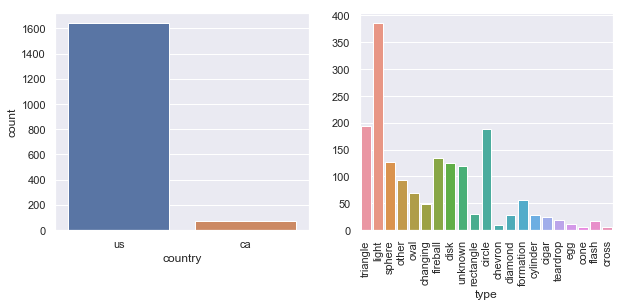

In [10]:
sns.set()
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
_country = sns.countplot(x=df['country'], ax=ax[0])
_type = sns.countplot(x=df['type'], ax=ax[1])
_type.set_xticklabels(labels=df.type.unique(), rotation=90)
_type = plt.ylabel('')

plt.show()

To be able to work with the categorical features and fit them into a model, I will convert them to numerical values. For the country column lets replace US with 1 and non-US countries with 0. For the type column lets one-hot-encode all types (create a column for each type). Another thing to note is the high imbalance in the country column. I'll deal with this later on by enabling stratify sampling in the train-test-split.

In [11]:
df['country'] = np.where(df['country']=='us', 1, 0) 
df_type = pd.get_dummies(df['type'], drop_first=True)
df = pd.concat([df, df_type], axis=1)

Next, let's tackle the date column and extract the month and the year of the sighting to use them as a feature in our model.

In [12]:
df['month'] = df['date'].apply(lambda date: date.month) #iterate over all date-values and extract the month
df['year'] = df['date'].apply(lambda date: date.year) #iterate over all date-values and extract the year

df[['date', 'month', 'year']].head()

,date,month,year
3,2002-11-21 05:45:00,11,2002
5,2012-06-16 23:00:00,6,2012
8,2013-06-09 00:00:00,6,2013
9,2013-04-26 23:27:00,4,2013
10,2013-09-13 20:30:00,9,2013


**Feature Selection**

1. remove redundant features
2. create tfidf text-vector and filter high-weighted words

1.

In [13]:
corr = df[['seconds','seconds_log','minutes']].corr()
corr.style.background_gradient(cmap='coolwarm')

,seconds,seconds_log,minutes
seconds,1,0.8543,0.97926
seconds_log,0.8543,1,0.823576
minutes,0.97926,0.823576,1


As you can see seconds, seconds_log and minutes correlate with each other. I will remove seconds and minutes and only keep seconds_log.

There are also several features related to location. I am going to drop all except the country column we updated with numerical values.

Same goes for the date related features. I am going to keep the newly created month and year columns but remove the other ones ('date', 'recorded'). Length-of-time can be removed aswell, because we already extracted the minute column and decided to work with seconds.

In [14]:
to_drop = ["city", "date", "lat", "length_of_time", "long", "minutes", "recorded", "seconds", "state"]
df = df.drop(to_drop, axis = 1)

2.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()
desc_tfidf = tfidf_vec.fit_transform(df['desc'])
print(desc_tfidf.toarray().shape) #1718 rows and 3235 columns, one column for each feature has been created
vocab = {v: k for k, v in tfidf_vec.vocabulary_.items()} #reverse key and value from original vocab (tfidf_vec.vocabulary)
#zipped_row = dict(zip(desc_tfidf.indices, desc_tfidf.data)) #zip index and weights
filtered_words = words_to_filter(vocab, tfidf_vec.vocabulary_, desc_tfidf, 5) #filtered top 5 weighted words for each description

#The Sighting-Description column 'Desc' has been vectorized, so we don't need the original column anymore.
df = df.drop("desc", axis = 1)

(1718, 3235)


In [16]:
X = df.drop(['type', 'country'], axis = 1)
y = df['country'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25, stratify = y)

### Classifying the country of a UFO Sighting

1. KNeighborsClassifier
2. Logistic Regression

**KNeighborsClassifier**

n_neighbors = Number of neighbors

In [17]:
knn_class = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(5, 16, 1)} 

grid_knn_class = GridSearchCV(
    estimator=knn_class,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=4,
    cv=5,
    refit=True, return_train_score=True)

grid_knn_class.fit(X_train, y_train)

print("Tuned KNeighborsClassifier Parameters: {}".format(grid_knn_class.best_params_)) 
print("Best score: {}".format(grid_knn_class.best_score_))
print("Holdout-set Score: {}".format(grid_knn_class.score(X_test, y_test)))

Tuned KNeighborsClassifier Parameters: {'n_neighbors': 7}
Best score: 0.9565217391304348
Holdout-set Score: 0.9558139534883721


**Logistic Regression**

C controls the inverse of the regularization strength. A large C can lead to an overfit model, while a small C can lead to an underfit model. I'll define a c-space and let the gridsearch decide which one scores the best and test it out with the holdout-set in the end, similar to the KNN Model.

In [18]:
from sklearn.linear_model import LogisticRegression

#hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

logreg = LogisticRegression(solver='lbfgs', max_iter=1000)

logreg_cv = GridSearchCV(logreg, param_grid, 
                         cv=5, 
                         scoring='accuracy',
                         n_jobs=4,
                         refit=True, return_train_score=True)



logreg_cv.fit(X_train, y_train)

#tuned parameters and score results
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))
print("Holdout-set Score: {}".format(logreg_cv.score(X_test, y_test)))

Tuned Logistic Regression Parameters: {'C': 1e-05}
Best score is 0.9565217391304348
Holdout-set Score: 0.9558139534883721


### Classifying the type of a UFO Sighting

**Multinomial Naive Bayes**

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. **However, in practice, fractional counts such as tf-idf may also work.**


The Multinomial naive bayes applies the Bayes theorem with the assumption of conditional idependence between every pair of a feature.

--------------
$$ P(A \mid B) = \frac{P(B \mid A) \, P(A)}{P(B)} $$

In [19]:
filtered_text = desc_tfidf[:, list(filtered_words)]

X = filtered_text.toarray()
y = df['type'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25, stratify = y)

In [20]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
print(nb.score(X_test, y_test))

0.26046511627906976


**Conclusion**

The score to predict the country of the sighting (us or not us) is pretty good on both KNN and Logistic Regression!

Sadly, the model performance in predicting the type of the UFO-Sighting is really bad. Further investigating the text or finding other features that are useful in predicting the type would be the next step.